<a href="https://colab.research.google.com/github/hauduong05/NLP_basics/blob/main/rnn_name_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/datasets

/content/drive/MyDrive/datasets


In [4]:
import os
import io
import glob
import torch
import random
import unicodedata
import string
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [8]:
# prepare data

ALL_LETTERS = string.ascii_letters + " ,.;'"
N_LETTERS = len(ALL_LETTERS)

# transform data to ascii
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

# load data to all categories and all lines in each category
def load_data():
    all_categories = []
    category_lines = {}

    def find_files(path):
        return glob.glob(path)

    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('names/*.txt'):
        lines = read_lines(filename)
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        category_lines[category] = lines
    return all_categories, category_lines


def letter_to_index(letter):
    return ALL_LETTERS.find(letter)


def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

# radom example to train
def random_training_example(all_categories, category_lines):
    def random_choice(a):
        idx = random.randint(0, len(a) - 1)
        return a[idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.output = nn.Linear(input_size + self.hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.hidden(combined)
        output = self.output(combined)
        output = self.softmax(output)
        return output, hidden

In [9]:
all_categories, category_lines = load_data()
n_categories = len(all_categories)
hidden_size = 128

rnn = RNN(N_LETTERS, hidden_size, n_categories)
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [10]:
# train

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return output, loss.item()


def category_from_output(output):
    idx = torch.argmax(output).item()
    return all_categories[idx]


current_loss = 0
all_loss = []
plot_step, print_step = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(all_categories, category_lines)
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i + 1) % plot_step == 0:
        all_loss.append(current_loss / plot_step)
        current_loss = 0

    if (i + 1) % print_step == 0:
        guess = category_from_output(output)
        print(f' loss = {loss:.4f}, correct = {category} - guess = {guess}')

 loss = 3.0232, correct = Arabic - guess = Irish
 loss = 2.9627, correct = German - guess = Portuguese
 loss = 3.5928, correct = Russian - guess = Portuguese
 loss = 0.8909, correct = Vietnamese - guess = Vietnamese
 loss = 3.8667, correct = Scottish - guess = Korean
 loss = 1.7651, correct = Scottish - guess = Scottish
 loss = 2.4414, correct = Spanish - guess = Dutch
 loss = 1.0434, correct = Arabic - guess = Arabic
 loss = 1.4224, correct = Irish - guess = Irish
 loss = 3.0149, correct = English - guess = Czech
 loss = 1.3114, correct = Vietnamese - guess = Chinese
 loss = 3.0538, correct = Italian - guess = French
 loss = 1.4318, correct = Italian - guess = Spanish
 loss = 2.6904, correct = French - guess = Vietnamese
 loss = 1.6570, correct = Japanese - guess = French
 loss = 1.9288, correct = Chinese - guess = Korean
 loss = 0.7578, correct = Czech - guess = Czech
 loss = 1.5353, correct = Polish - guess = Czech
 loss = 0.8857, correct = Italian - guess = Italian
 loss = 0.4948, 

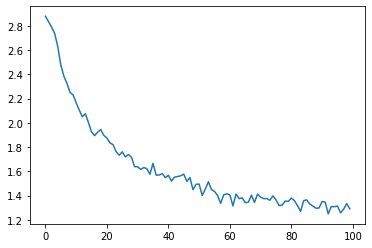

In [11]:
# plot training loss

plt.figure()
plt.plot(all_loss)
plt.show()

In [12]:
# predict 

def predict(input_line):
    print(input_line)
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        guess = category_from_output(output)
        print(guess)

while True:
    inp = input("Input : ")
    if inp == 'break':
        break
    predict(inp)

Input : Nguyen
Nguyen
Vietnamese
Input : Yong
Yong
Korean
Input : Zhang
Zhang
Chinese
Input : break
